# 상위 5호가씩 사용한 ordexe 데이터로 학습한 Transformer 모델

# (1) 라이브러리 import

In [1]:
import os
import glob
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
import time

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback, EarlyStopping

# (2) 데이터 불러오기

In [2]:
#현재 디렉토리 확인
os.getcwd()

'C:\\Users\\user\\Downloads'

In [3]:
df = pd.read_csv("final_data.csv")
df

,total_ask_size,total_bid_size,1_ask_size,1_bid_size,2_ask_size,2_bid_size,3_ask_size,3_bid_size,4_ask_size,4_bid_size,5_ask_size,5_bid_size,trade_price,trade_volume,spread,imbalance,totalSize_ratio,trade_price_10min_later
0,0.499237,0.925602,0.032215,0.005979,0.006364,0.016141,0.122240,0.063830,0.000120,0.300359,0.001020,0.080266,83658000.0,0.000100,36000.0,0.658003,4.848005,1
1,0.501627,0.896695,0.032215,0.005979,0.006364,0.016141,0.122240,0.300359,0.000120,0.080266,0.001020,0.142020,83658000.0,0.000100,36000.0,0.636619,4.503863,1
2,0.501627,0.861926,0.032215,0.000061,0.006364,0.005979,0.122240,0.016141,0.000120,0.300359,0.001020,0.080266,83658000.0,0.000100,33000.0,0.634520,4.472258,1
3,0.500431,0.861926,0.031019,0.000061,0.006364,0.005979,0.122240,0.016141,0.000120,0.300359,0.001020,0.080266,83658000.0,0.001195,33000.0,0.636627,4.503981,1
4,0.500431,0.878067,0.031019,0.000061,0.006364,0.005979,0.122240,0.032282,0.000120,0.300359,0.001020,0.080266,83658000.0,0.001195,33000.0,0.642842,4.599765,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5986348,2.895852,1.073478,0.042948,0.012691,0.486217,0.024640,0.293135,0.072440,0.659504,0.006471,0.990263,0.148616,96238000.0,0.000829,20000.0,-0.567196,0.276165,0
5986349,2.894194,1.073478,0.041290,0.012691,0.486217,0.024640,0.293135,0.072440,0.659504,0.006471,0.990263,0.148616,96238000.0,0.001658,20000.0,-0.566991,0.276331,0
5986350,2.899389,1.068375,0.046486,0.012691,0.486217,0.024640,0.293135,0.000200,0.659504,0.072440,0.990263,0.006471,96238000.0,0.001658,20000.0,-0.701932,0.175135,0
5986351,2.910013,1.068375,0.057109,0.012691,0.486217,0.024640,0.293135,0.000200,0.659504,0.072440,0.990263,0.006471,96238000.0,0.001658,20000.0,-0.702908,0.174462,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986353 entries, 0 to 5986352
Data columns (total 18 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   total_ask_size           float64
 1   total_bid_size           float64
 2   1_ask_size               float64
 3   1_bid_size               float64
 4   2_ask_size               float64
 5   2_bid_size               float64
 6   3_ask_size               float64
 7   3_bid_size               float64
 8   4_ask_size               float64
 9   4_bid_size               float64
 10  5_ask_size               float64
 11  5_bid_size               float64
 12  trade_price              float64
 13  trade_volume             float64
 14  spread                   float64
 15  imbalance                float64
 16  totalSize_ratio          float64
 17  trade_price_10min_later  int64  
dtypes: float64(17), int64(1)
memory usage: 822.1 MB


# (3) 데이터 전처리

## (3-1) X와 y 데이터셋 분리

In [5]:
#X와 y 데이터셋 분리
X = df.drop(columns=['trade_price_10min_later']).values
y = df['trade_price_10min_later'].values #trade_price_10min_later가 target

## (3-2) 데이터 스케일링

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.83970395, -0.47916167, -0.24206646, ...,  0.62393175,
         1.65643757,  0.37191828],
       [-0.83885299, -0.49232116, -0.24206646, ...,  0.62393175,
         1.61298039,  0.33100242],
       [-0.83885299, -0.50814929, -0.24206646, ...,  0.49482269,
         1.60871529,  0.32724475],
       ...,
       [ 0.01487833, -0.41416574, -0.22858168, ..., -0.0646499 ,
        -1.10724542, -0.18365127],
       [ 0.01866088, -0.41416574, -0.21854347, ..., -0.0646499 ,
        -1.10922769, -0.1837313 ],
       [ 0.01495956, -0.41416574, -0.22836611, ..., -0.0646499 ,
        -1.10728813, -0.183653  ]])

## (3-3) 시퀀스 데이터 생성

In [7]:
timesteps = 20 #20개 행씩 묶어서 진행 (이 부분은 hyper-parameter로 조정 가능)
X_sequences, y_sequences = [], []

for i in range(len(X_scaled) - timesteps):
    X_sequences.append(X_scaled[i:i+timesteps]) #현재부터 다음 20개까지 데이터를 슬라이싱하여 한 묶음으로
    y_sequences.append(y[i+timesteps])

#dtype을 float64 -> float32로 변경 (메모리 문제 방지를 위해)
#float32는 소수점 7자리까지 보장
X_sequences = np.array(X_sequences, dtype=np.float32) #10개 시점의 X 데이터
y_sequences = np.array(y_sequences, dtype=np.float32) #그 다음 시점의 y값

#차원 확인
print(f'X_sequences 차원: {X_sequences.shape}')
print(f'y_sequences 차원: {y_sequences.shape}')

X_sequences 차원: (5986333, 20, 17)
y_sequences 차원: (5986333,)


## (3-4) train, test 셋 분리

In [8]:
#시퀀스 데이터의 train, test 분리는 시간 패턴에 따른 과적합 방지를 위해 비시계열성 데이터처럼 섞어서 진행해야 함
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42) #8:2 분리

#차원 확인
print(f'X_train 차원: {X_train.shape}')
print(f'y_train 차원: {y_train.shape}')
print(f'X_test 차원: {X_test.shape}')
print(f'y_test 차원: {y_test.shape}')

X_train 차원: (4789066, 20, 17)
y_train 차원: (4789066,)
X_test 차원: (1197267, 20, 17)
y_test 차원: (1197267,)


# (4) Transformer 모델링

## (4-1) 모델 구조 설정

In [9]:
#Transformer 모델 정의
inputs = layers.Input(shape=(timesteps, X_train.shape[2]))

#[첫 번째 완전연결층]
x = layers.Dense(64, activation='relu')(inputs) #64개 유닛 사용
x = layers.LayerNormalization()(x) #입력 차원을 표준화하여 학습을 안정화시킴
x = layers.Dropout(0.3)(x)  #과적합 방지를 위한 Dropout

#Transformer block
attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x) #4개의 헤드를 가지는 다중 헤드 어텐션 레이어
x = layers.Add()([x, attn_output])  #원본 입력값(x)와 어텐션 출력을 더하는 잔차 연결 사용하여 정보 손실 방지하고 학습을 더 원활하게 함
x = layers.LayerNormalization()(x)
x = layers.Dropout(0.3)(x)

#시퀀스 차원을 축소하여 단일 값으로 만듦
x = layers.GlobalAveragePooling1D()(x)  #10개의 타임스텝에서 평균값을 취해 하나의 값으로 축소

#[두 번째 완전연결층]
x = layers.Dense(32, activation='relu')(x) #32개 유닛 사용
x = layers.Dropout(0.3)(x)

#[출력층]
outputs = layers.Dense(1, activation='sigmoid')(x)  # 이진 분류 문제이므로 sigmoid 사용

#모델 구성
transformer_model = models.Model(inputs=inputs, outputs=outputs)

transformer_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 17)]     0           []                               
                                                                                                  
 dense (Dense)                  (None, 20, 64)       1152        ['input_1[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 20, 64)      128         ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 dropout (Dropout)              (None, 20, 64)       0           ['layer_normalization[0][0]']

## (4-2) 모델 학습

Training Progress:   0%|                                                                        | 0/10 [00:00<?, ?it/s]

Epoch 1/10
74830/74830 [==============================] - ETA: 0s - loss: 0.6894 - accuracy: 0.5310

Training Progress:  10%|███▏                            | 1/10 [21:13<3:11:01, 1273.53s/it, loss=0.689, val_loss=0.687]

74830/74830 [==============================] - 1270s 17ms/step - loss: 0.6894 - accuracy: 0.5310 - val_loss: 0.6871 - val_accuracy: 0.5381
Epoch 2/10
74830/74830 [==============================] - ETA: 0s - loss: 0.6850 - accuracy: 0.5445

Training Progress:  20%|██████▍                         | 2/10 [41:30<2:45:23, 1240.48s/it, loss=0.685, val_loss=0.685]

74830/74830 [==============================] - 1217s 16ms/step - loss: 0.6850 - accuracy: 0.5445 - val_loss: 0.6849 - val_accuracy: 0.5450
Epoch 3/10
74830/74830 [==============================] - ETA: 0s - loss: 0.6826 - accuracy: 0.5501

Training Progress:  30%|█████████                     | 3/10 [1:02:00<2:24:09, 1235.69s/it, loss=0.683, val_loss=0.686]

74830/74830 [==============================] - 1230s 16ms/step - loss: 0.6826 - accuracy: 0.5501 - val_loss: 0.6856 - val_accuracy: 0.5455
Epoch 4/10
74830/74830 [==============================] - ETA: 0s - loss: 0.6810 - accuracy: 0.5536

Training Progress:  40%|████████████                  | 4/10 [1:22:19<2:02:53, 1228.91s/it, loss=0.681, val_loss=0.683]

74830/74830 [==============================] - 1218s 16ms/step - loss: 0.6810 - accuracy: 0.5536 - val_loss: 0.6832 - val_accuracy: 0.5480
Epoch 5/10
74829/74830 [============================>.] - ETA: 0s - loss: 0.6799 - accuracy: 0.5559

Training Progress:  50%|███████████████▌               | 5/10 [1:42:30<1:41:51, 1222.37s/it, loss=0.68, val_loss=0.684]

74830/74830 [==============================] - 1211s 16ms/step - loss: 0.6799 - accuracy: 0.5559 - val_loss: 0.6838 - val_accuracy: 0.5502
Epoch 6/10
74830/74830 [==============================] - ETA: 0s - loss: 0.6792 - accuracy: 0.5570

Training Progress:  60%|██████████████████            | 6/10 [2:02:38<1:21:10, 1217.71s/it, loss=0.679, val_loss=0.683]

74830/74830 [==============================] - 1209s 16ms/step - loss: 0.6792 - accuracy: 0.5570 - val_loss: 0.6827 - val_accuracy: 0.5515
Epoch 7/10
74830/74830 [==============================] - ETA: 0s - loss: 0.6786 - accuracy: 0.5585

Training Progress:  70%|█████████████████████         | 7/10 [2:22:30<1:00:27, 1209.15s/it, loss=0.679, val_loss=0.682]

74830/74830 [==============================] - 1192s 16ms/step - loss: 0.6786 - accuracy: 0.5585 - val_loss: 0.6824 - val_accuracy: 0.5504
Epoch 8/10
74828/74830 [============================>.] - ETA: 0s - loss: 0.6784 - accuracy: 0.5585

Training Progress:  80%|█████████████████████████▌      | 8/10 [2:42:07<39:57, 1198.80s/it, loss=0.678, val_loss=0.683]

74830/74830 [==============================] - 1177s 16ms/step - loss: 0.6784 - accuracy: 0.5585 - val_loss: 0.6830 - val_accuracy: 0.5525
Epoch 9/10
74827/74830 [============================>.] - ETA: 0s - loss: 0.6782 - accuracy: 0.5587

Training Progress:  90%|████████████████████████████▊   | 9/10 [3:02:53<20:13, 1213.79s/it, loss=0.678, val_loss=0.683]

74830/74830 [==============================] - 1247s 17ms/step - loss: 0.6782 - accuracy: 0.5587 - val_loss: 0.6832 - val_accuracy: 0.5523
Epoch 10/10
74829/74830 [============================>.] - ETA: 0s - loss: 0.6779 - accuracy: 0.5594

Training Progress: 100%|███████████████████████████████| 10/10 [3:22:23<00:00, 1200.05s/it, loss=0.678, val_loss=0.683]

74830/74830 [==============================] - 1169s 16ms/step - loss: 0.6779 - accuracy: 0.5594 - val_loss: 0.6829 - val_accuracy: 0.5521


Training Progress: 100%|███████████████████████████████| 10/10 [3:22:23<00:00, 1214.32s/it, loss=0.678, val_loss=0.683]


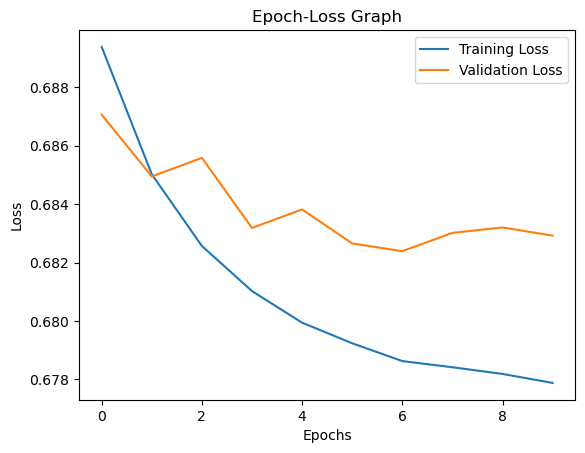

In [10]:
#모델 compile
transformer_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#조기 종료(EarlyStopping) 콜백 설정
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

#학습 시각화 및 진행 표시를 위한 Callback 설정
class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.tqdm = tqdm(total=self.epochs, desc='Training Progress')

    def on_epoch_end(self, epoch, logs=None):
        self.tqdm.update(1)
        self.tqdm.set_postfix(loss=logs['loss'], val_loss=logs['val_loss'])

    def on_train_end(self, logs=None):
        self.tqdm.close()

#학습 진행
history = transformer_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test),
                                callbacks=[TQDMProgressBar(), early_stopping])

#Epoch-Loss 그래프 시각화
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Epoch-Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## (4-3) 모델 평가

37415/37415 [==============================] - 163s 4ms/step - loss: 0.6830 - accuracy: 0.5525
Test Loss: 0.6830, Test Accuracy: 0.5525
37415/37415 [==============================] - 157s 4ms/step


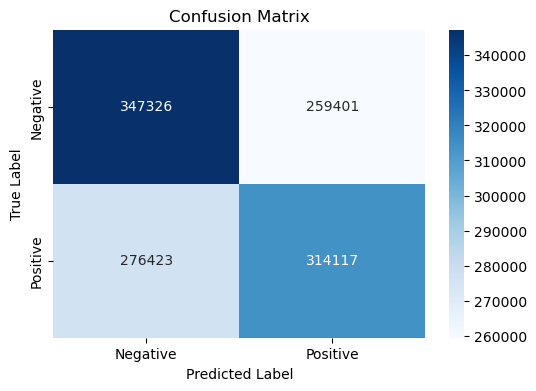

              precision    recall  f1-score   support

    Negative       0.56      0.57      0.56    606727
    Positive       0.55      0.53      0.54    590540

    accuracy                           0.55   1197267
   macro avg       0.55      0.55      0.55   1197267
weighted avg       0.55      0.55      0.55   1197267



In [12]:
#모델 평가
loss, accuracy = transformer_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

#예측값 생성
y_pred = transformer_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int) #확률을 0과 1로 변환

#혼동 행렬 시각화
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 정밀도, 재현율, F1-스코어 출력
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

In [13]:
#예측된 클래스 출력
print("Predicted class labels (0 or 1):", y_pred.flatten())

Predicted class labels (0 or 1): [0 0 0 ... 0 1 0]


In [14]:
#모델 예측값
transformer_model.predict(X_test)

37415/37415 [==============================] - 153s 4ms/step


array([[0.32991806],
       [0.24312487],
       [0.46848372],
       ...,
       [0.40405476],
       [0.51392454],
       [0.34122843]], dtype=float32)

# (5) 모델 저장

In [15]:
#첫 번째 파라미터 조합의 transformer 모델 저장
transformer_model.save("transformer_2.h5")